### Paritioning Comparison for different models

In [3]:
import numpy as np
import pandas as pd
import os 
import sys
import itertools
import time
import matplotlib.pyplot as plt

In [4]:
# Set Helvetica font and IEEE style parameters
plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

In [5]:
data_dir = '../data/mapping_comparison_13October'

In [7]:
"""
Load and combine mapping comparison data for all models.

For each model:
- Loads mapping_comparison_{model_name}.csv (row_wise, column_wise)
- Loads random_mapping_comparison_{model_name}.csv (random mapping with multiple runs)
- Averages the random mapping results
- Combines all three strategies (row_wise, column_wise, random_avg) into a single dataframe
"""

import glob

# Directory containing the CSV files

# Find all unique model names
mapping_files = glob.glob(f'{data_dir}/mapping_comparison_*.csv')
model_names = [f.replace(f'{data_dir}/mapping_comparison_', '').replace('.csv', '') for f in mapping_files]
model_names = sorted(model_names)

print(f"Found {len(model_names)} models:")
for model in model_names:
    print(f"  - {model}")

# Dictionary to store dataframes for each model
model_dataframes = {}

for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"Processing: {model_name}")
    print(f"{'='*80}")
    
    # Load deterministic mappings (row_wise, column_wise)
    mapping_file = f'{data_dir}/mapping_comparison_{model_name}.csv'
    df_mapping = pd.read_csv(mapping_file)
    print(f"✓ Loaded {mapping_file}: {len(df_mapping)} rows")
    print(f"  Strategies: {df_mapping['mapping_strategy'].unique()}")
    
    # Load random mappings (multiple runs to average)
    random_file = f'{data_dir}/random_mapping_comparison_{model_name}.csv'
    try:
        df_random = pd.read_csv(random_file)
        print(f"✓ Loaded {random_file}: {len(df_random)} rows")
        
        # Average the random mapping results
        # Group by all columns except result_analytical and analytical_time
        #mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
        group_cols = ['mapping_strategy', 'num_partitions', 'parts_per_layer', 'total_tasks', 'result_analytical', 'analytical_time', 'partitioner_config', 'result_booksim', 'booksim_time', 'percentage_diff', 'time_gain']
        df_random_avg = df_random.groupby(group_cols, as_index=False).agg({
            'result_analytical': 'mean',
            'analytical_time': 'mean'
        })
        
        print(f"  Random runs: {len(df_random)} → averaged to {len(df_random_avg)} rows")
        print(f"  Average result_analytical: {df_random_avg['result_analytical'].iloc[0]:.0f} cycles")
        
        # Combine all strategies
        df_combined = pd.concat([df_mapping, df_random_avg], ignore_index=True)
        
    except FileNotFoundError:
        print(f"✗ No random mapping file found: {random_file}")
        print(f"  Using only deterministic mappings")
        df_combined = df_mapping.copy()
    
    # Store in dictionary
    model_dataframes[model_name] = df_combined
    
    print(f"\nCombined dataframe for {model_name}:")
    print(f"  Total rows: {len(df_combined)}")
    print(f"  Strategies: {df_combined['mapping_strategy'].unique()}")
    print(f"  Columns: {list(df_combined.columns)}")

print(f"\n{'='*80}")
print(f"Summary: Loaded {len(model_dataframes)} models")
print(f"{'='*80}")

Found 7 models:
  - AlexNet
  - MobileNetv1
  - ResNet32_early
  - ResNet32_late
  - ResNet32_mid
  - VGG_16_early
  - VGG_16_late

Processing: AlexNet


ParserError: Error tokenizing data. C error: Expected 11 fields in line 106, saw 13


In [11]:
"""
Load and process mapping comparison data from a single combined CSV file.

The CSV contains all mapping strategies:
- random_run0, random_run1, ..., random_runN (multiple random runs to average)
- row_wise (deterministic)
- column_wise (deterministic)
- ACO_row (Ant Colony Optimization with row-wise initialization)
- ACO (Ant Colony Optimization)
- GA_row (Genetic Algorithm with row-wise initialization)
- GA (Genetic Algorithm)
"""

import pandas as pd
import numpy as np
import glob

# Find all unique model names
mapping_files = glob.glob(f'{data_dir}/mapping_comparison_*.csv')
model_names = [f.replace(f'{data_dir}/mapping_comparison_', '').replace('.csv', '') for f in mapping_files]
model_names = sorted(model_names)

print(f"Found {len(model_names)} models:")
for model in model_names:
    print(f"  - {model}")

# Dictionary to store dataframes for each model
model_dataframes = {}

for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"Processing: {model_name}")
    print(f"{'='*80}")
    
    # Load the combined mapping file
    mapping_file = f'{data_dir}/mapping_comparison_{model_name}.csv'
    
    try:
        # Read CSV, handling NaN values
        df = pd.read_csv(mapping_file, na_values=['NaN', 'nan', ''])
        print(f"✓ Loaded {mapping_file}: {len(df)} rows")
        
        # Identify all unique strategies
        all_strategies = df['mapping_strategy'].unique()
        print(f"  Strategies found: {list(all_strategies)}")
        
        # Separate random runs from other strategies
        random_runs = df[df['mapping_strategy'].str.startswith('random_run', na=False)]
        other_strategies = df[~df['mapping_strategy'].str.startswith('random_run', na=False)]
        
        if len(random_runs) > 0:
            print(f"\n  Random runs: {len(random_runs)} entries")
            
            # Average the random runs
            # Only average the result columns, keep other columns from first entry
            random_avg = {
                'mapping_strategy': 'random',
                'num_partitions': random_runs['num_partitions'].iloc[0],
                'parts_per_layer': random_runs['parts_per_layer'].iloc[0],
                'total_tasks': random_runs['total_tasks'].iloc[0],
                'result_analytical': random_runs['result_analytical'].mean(),
                'analytical_time': random_runs['analytical_time'].mean(),
                'partitioner_config': random_runs['partitioner_config'].iloc[0],
                'result_booksim': random_runs['result_booksim'].mean() if random_runs['result_booksim'].notna().any() else np.nan,
                'booksim_time': random_runs['booksim_time'].mean() if random_runs['booksim_time'].notna().any() else np.nan,
                'percentage_diff': random_runs['percentage_diff'].mean() if random_runs['percentage_diff'].notna().any() else np.nan,
                'time_gain': random_runs['time_gain'].mean() if random_runs['time_gain'].notna().any() else np.nan
            }
            
            print(f"    Average result_analytical: {random_avg['result_analytical']:.0f} cycles")
            print(f"    Average result_booksim: {random_avg['result_booksim']:.0f} cycles" if not np.isnan(random_avg['result_booksim']) else "    Average result_booksim: NaN")
            
            # Create dataframe with averaged random results
            df_random_avg = pd.DataFrame([random_avg])
            
            # Combine averaged random with other strategies
            df_combined = pd.concat([df_random_avg, other_strategies], ignore_index=True)
        else:
            print(f"\n  No random runs found")
            df_combined = other_strategies.copy()
        
        # Sort strategies in a specific order for consistency
        strategy_order = ['random', 'row_wise', 'column_wise', 'ACO_row', 'ACO', 'GA_row', 'GA']
        df_combined['strategy_order'] = df_combined['mapping_strategy'].apply(
            lambda x: strategy_order.index(x) if x in strategy_order else 999
        )
        df_combined = df_combined.sort_values('strategy_order').drop('strategy_order', axis=1).reset_index(drop=True)
        
        # Store in dictionary
        model_dataframes[model_name] = df_combined
        
        print(f"\nProcessed dataframe for {model_name}:")
        print(f"  Total rows: {len(df_combined)}")
        print(f"  Strategies: {list(df_combined['mapping_strategy'].values)}")
        
        # Print summary statistics
        print(f"\n  Strategy Results (result_analytical):")
        for _, row in df_combined.iterrows():
            strategy = row['mapping_strategy']
            result = row['result_analytical']
            booksim = row['result_booksim']
            if pd.notna(result):
                result_str = f"{result:>12,.0f} cycles"
                if pd.notna(booksim):
                    result_str += f" (Booksim: {booksim:>12,.0f} cycles, diff: {row['percentage_diff']:.2f}%)"
                print(f"    {strategy:12s}: {result_str}")
        
    except FileNotFoundError:
        print(f"✗ File not found: {mapping_file}")
        continue
    except Exception as e:
        print(f"✗ Error loading {mapping_file}: {e}")
        continue

print(f"\n{'='*80}")
print(f"Summary: Loaded {len(model_dataframes)} models")
print(f"{'='*80}")

Found 7 models:
  - AlexNet
  - MobileNetv1
  - ResNet32_early
  - ResNet32_late
  - ResNet32_mid
  - VGG_16_early
  - VGG_16_late

Processing: AlexNet
✓ Loaded ../data/mapping_comparison_13October/mapping_comparison_AlexNet.csv: 106 rows
  Strategies found: ['random_run0', 'random_run1', 'random_run2', 'random_run3', 'random_run4', 'random_run5', 'random_run6', 'random_run7', 'random_run8', 'random_run9', 'random_run10', 'random_run11', 'random_run12', 'random_run13', 'random_run14', 'random_run15', 'random_run16', 'random_run17', 'random_run18', 'random_run19', 'random_run20', 'random_run21', 'random_run22', 'random_run23', 'random_run24', 'random_run25', 'random_run26', 'random_run27', 'random_run28', 'random_run29', 'random_run30', 'random_run31', 'random_run32', 'random_run33', 'random_run34', 'random_run35', 'random_run36', 'random_run37', 'random_run38', 'random_run39', 'random_run40', 'random_run41', 'random_run42', 'random_run43', 'random_run44', 'random_run45', 'random_run46'

In [12]:
model_dataframes['AlexNet']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,133.0,12.0,134.0,22889055.39,7.508647,"(1, 2, 3)",NaN,NaN,NaN,NaN
1,row_wise,133.0,12.0,134.0,16425584.00,2.561400,"(1, 2, 3)",16436816.0,1303.2646,0.07,508.8041
2,column_wise,133.0,12.0,134.0,16425559.00,2.215900,"(1, 2, 3)",16436316.0,1380.3459,0.07,622.9400
3,ACO_row,NaN,NaN,NaN,16425650.00,2.390600,"(1, 2, 3)",16435793.0,648.7068,0.06,271.3527
4,ACO,NaN,NaN,NaN,16425587.00,4.833600,"(1, 2, 3)",22026713.0,817.0676,25.43,169.0386
5,GA_row,NaN,NaN,NaN,16425392.00,1.537600,"(1, 2, 3)",16437381.0,654.3423,0.07,425.5547
6,GA,NaN,NaN,NaN,16425256.00,1.700600,"(1, 2, 3)",16436640.0,738.1883,0.07,434.0829


In [13]:
model_dataframes['MobileNetv1']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,163.0,6.0,164.0,1065252.02,9.52137,"(0, 2, 3)",NaN,NaN,NaN,NaN
1,row_wise,163.0,6.0,164.0,970818.00,3.60380,"(0, 2, 3)",974853.0,88.2207,0.41,24.4800
2,column_wise,163.0,6.0,164.0,970049.00,7.82400,"(0, 2, 3)",975919.0,89.6569,0.60,11.4593
3,ACO_row,NaN,NaN,NaN,965308.00,3.14230,"(0, 2, 3)",957066.0,34.1859,0.86,10.8791
4,ACO,NaN,NaN,NaN,1658587.00,3.14670,"(0, 2, 4)",1676775.0,105.2867,1.08,33.4598
5,GA_row,NaN,NaN,NaN,1282612.00,9.53400,"(0, 2, 5)",1305588.0,110.7282,1.76,11.6140
6,GA,NaN,NaN,NaN,1282662.00,6.14180,"(0, 2, 5)",1303515.0,114.0407,1.60,18.5679


In [14]:
model_dataframes['ResNet32_early']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,217.0,8.0,176.0,1951972.62,13.247221,"(0, 2, 4)",NaN,NaN,NaN,NaN
1,row_wise,217.0,8.0,176.0,1640813.00,12.718800,"(0, 2, 4)",1716346.0,310.0435,4.40,24.3767
2,column_wise,217.0,8.0,176.0,1639613.00,6.388100,"(0, 2, 4)",1700222.0,308.6574,3.56,48.3172
3,ACO_row,NaN,NaN,NaN,1289623.00,9.493400,"(0, 2, 5)",1303547.0,107.2838,1.07,11.3008
4,ACO,NaN,NaN,NaN,1659001.00,5.416000,"(0, 2, 4)",1676936.0,105.9396,1.07,19.5606
5,GA_row,NaN,NaN,NaN,1285099.00,7.805800,"(0, 2, 5)",1300852.0,109.7147,1.21,14.0556
6,GA,NaN,NaN,NaN,1284778.00,6.675400,"(0, 2, 5)",1300828.0,105.9896,1.23,15.8777


In [15]:
model_dataframes['ResNet32_mid']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,261.0,10.0,212.0,1585481.55,23.357553,"(0, 2, 5)",NaN,NaN,NaN,NaN
1,row_wise,261.0,10.0,212.0,1283481.00,13.228100,"(0, 2, 5)",1306544.0,391.3894,1.77,29.5877
2,column_wise,261.0,10.0,212.0,1282309.00,7.133000,"(0, 2, 5)",1303077.0,387.3043,1.59,54.2975
3,ACO_row,NaN,NaN,NaN,23885156.00,0.165600,"(1, 2, 1)",23876553.0,723.9454,0.04,4372.4175
4,ACO,NaN,NaN,NaN,23885083.00,0.119100,"(1, 2, 1)",23893939.0,730.9745,0.04,6136.4608
5,GA,NaN,NaN,NaN,23884236.00,0.026400,"(1, 2, 1)",23882476.0,726.9779,0.01,27566.3237


In [16]:
model_dataframes['ResNet32_late']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,487.0,18.0,398.0,8772845.7,94.466047,"(1, 3, 3)",NaN,NaN,NaN,NaN
1,row_wise,487.0,18.0,398.0,801460.0,100.919400,"(1, 3, 3)",728356.0,636.5106,10.04,6.3071
2,column_wise,487.0,18.0,398.0,723271.0,101.370600,"(1, 3, 3)",726656.0,646.1858,0.47,6.3745
3,ACO_row,NaN,NaN,NaN,23885090.0,0.134400,"(1, 2, 1)",23880667.0,738.7109,0.02,5497.3794
4,ACO,NaN,NaN,NaN,23687636.0,0.114600,"(0,1,3)",23686509.0,707.0739,0.00,6168.7514
5,GA_row,NaN,NaN,NaN,23687178.0,0.043200,"(0, 1, 3)",23685434.0,702.5354,0.01,16252.7012
6,GA,NaN,NaN,NaN,23687131.0,0.047400,"(0, 1, 3)",23685721.0,702.7806,0.01,14837.2682


In [20]:
model_dataframes['VGG_16_early']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,41.0,4.0,42.0,24606100.05,0.573555,"(1, 2, 1)",NaN,NaN,NaN,NaN
1,row_wise,41.0,4.0,42.0,23885159.00,0.403200,"(1, 2, 1)",23906666.0,1639.4886,0.09,4066.3589
2,column_wise,41.0,4.0,42.0,23885146.00,0.458000,"(1, 2, 1)",23904391.0,1678.8937,0.08,3665.3294
3,ACO_row,NaN,NaN,NaN,23885103.00,0.200100,"(1, 2, 1)",23896580.0,760.5610,0.05,3801.2997
4,ACO,NaN,NaN,NaN,23687978.00,0.096700,"(0, 1, 3)",23685891.0,762.3339,0.01,7886.8425
5,GA_row,NaN,NaN,NaN,23687274.00,0.062600,"(0, 1, 3)",23685778.0,743.9477,0.01,11882.4477
6,GA,NaN,NaN,NaN,23687052.00,0.039600,"(0, 1, 3)",23685135.0,720.4863,0.01,18180.3544


In [19]:
model_dataframes['VGG_16_late']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config,result_booksim,booksim_time,percentage_diff,time_gain
0,random,34.0,3.0,35.0,24351647.34,0.373743,"(0, 1, 3)",NaN,NaN,NaN,NaN
1,row_wise,34.0,3.0,35.0,23687640.00,0.200300,"(0, 1, 3)",23686503.0,1604.4781,0.00,8009.8894
2,column_wise,34.0,3.0,35.0,23687639.00,0.198700,"(0, 1, 3)",23686507.0,1584.2498,0.00,7973.3724
3,ACO_row,NaN,NaN,NaN,23687579.00,0.104100,"(0, 1, 3)",23686434.0,728.3290,0.00,6993.6182
4,ACO,NaN,NaN,NaN,23687940.00,0.094700,"(0, 1, 3)",23686467.0,756.9784,0.01,7991.5770
5,GA_row,NaN,NaN,NaN,23687119.00,0.047700,"(0, 1, 3)",23685432.0,743.2429,0.01,15565.9204
6,GA,NaN,NaN,NaN,23687028.00,0.050600,"(0, 1, 3)",23685458.0,717.5122,0.01,14184.2781


In [24]:
"""
Normalize the results for each model to the random mapping baseline.

For each model:
- Extract the random mapping latency as the baseline (= 1.0)
- Normalize all strategies (row_wise, column_wise, random) relative to this baseline
- Create normalized dataframe with a new column 'result_normalized'
"""

model_dataframes_normalised = {}

print(f"{'='*80}")
print(f"Normalizing results to random mapping baseline")
print(f"{'='*80}")

for model_name, df in model_dataframes.items():
    print(f"\nProcessing: {model_name}")
    
    # Get random mapping latency as baseline
    random_row = df[df['mapping_strategy'] == 'random']
    
    if len(random_row) > 0:
        baseline = random_row['result_analytical'].values[0]
        print(f"  Random baseline: {baseline:,.0f} cycles")
        
        # Create a copy and add normalized column
        df_normalized = df.copy()
        df_normalized['result_normalized'] = df_normalized['result_analytical'] / baseline
        
        # Store normalized dataframe
        model_dataframes_normalised[model_name] = df_normalized
        
        print(f"  Normalized values:")
        for _, row in df_normalized.iterrows():
            print(f"    {row['mapping_strategy']:12s}: {row['result_normalized']:.4f} "
                  f"({row['result_analytical']:>12,.0f} cycles)")
    else:
        print(f"  ✗ No random mapping found - skipping normalization")
        # Keep original dataframe without normalization
        model_dataframes_normalised[model_name] = df.copy()

print(f"\n{'='*80}")
print(f"Summary: Normalized {len(model_dataframes_normalised)} models")
print(f"{'='*80}")

Normalizing results to random mapping baseline

Processing: AlexNet
  Random baseline: 22,889,055 cycles
  Normalized values:
    random      : 1.0000 (  22,889,055 cycles)
    row_wise    : 0.7176 (  16,425,584 cycles)
    column_wise : 0.7176 (  16,425,559 cycles)
    ACO_row     : 0.7176 (  16,425,650 cycles)
    ACO         : 0.7176 (  16,425,587 cycles)
    GA_row      : 0.7176 (  16,425,392 cycles)
    GA          : 0.7176 (  16,425,256 cycles)

Processing: MobileNetv1
  Random baseline: 1,065,252 cycles
  Normalized values:
    random      : 1.0000 (   1,065,252 cycles)
    row_wise    : 0.9114 (     970,818 cycles)
    column_wise : 0.9106 (     970,049 cycles)
    ACO_row     : 0.9062 (     965,308 cycles)
    ACO         : 1.5570 (   1,658,587 cycles)
    GA_row      : 1.2040 (   1,282,612 cycles)
    GA          : 1.2041 (   1,282,662 cycles)

Processing: ResNet32_early
  Random baseline: 1,951,973 cycles
  Normalized values:
    random      : 1.0000 (   1,951,973 cycles)
  

In [52]:
def plot_mapping_comparison_ieee(model_dataframes, figsize=(7.0, 3.5), use_norm = False, save_path=None, dpi=300):
    """
    Create IEEE conference paper style grouped bar plot comparing mapping strategies across models.
    
    Shows latency for each model with 5 bars: random, row-wise, column-wise, ACO (placeholder), GA (placeholder)
    
    Parameters:
    -----------
    model_dataframes : dict
        Dictionary with model names as keys and dataframes as values
    figsize : tuple
        Figure size in inches (default: 7.0x3.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Map internal names to display names
    name_mapping = {
        'AlexNet': 'AlexNet',
        'VGG_16_early': 'VGG16\nearly layers',
        'VGG_16_late': 'VGG16\nlate layers',
        'MobileNetv1': 'MobileNetV1',
        'ResNet32_early': 'ResNet32\nearly blocks',
        'ResNet32_mid': 'ResNet32\nmid blocks',
        'ResNet32_late': 'ResNet32\nlate blocks'
    }
    
    # Order of models for display
    #model_order = ['AlexNet', 'VGG_16_early', 'VGG_16_late', 'MobileNetv1', 
    #               'ResNet32_early', 'ResNet32_mid', 'ResNet32_late']

    model_order = ['AlexNet', 'VGG_16_early', 'VGG_16_late',
                   'ResNet32_early']
    
    # Prepare data for plotting
    models_display = []
    random_values = []
    rowwise_values = []
    colwise_values = []
    aco_values = []
    ga_values = []
    
    for model_key in model_order:
        if model_key in model_dataframes:
            df = model_dataframes[model_key]
            models_display.append(name_mapping[model_key])
            
            if use_norm:
                # Extract normalized latency for each strategy
                random_val = df[df['mapping_strategy'] == 'random']['result_normalized'].values
                rowwise_val = df[df['mapping_strategy'] == 'row_wise']['result_normalized'].values
                colwise_val = df[df['mapping_strategy'] == 'column_wise']['result_normalized'].values
                aco_val = df[df['mapping_strategy'] == 'ACO']['result_normalized'].values
                ga_val = df[df['mapping_strategy'] == 'GA']['result_normalized'].values
            else:
                # Extract latency for each strategy
                random_val = df[df['mapping_strategy'] == 'random']['result_analytical'].values
                rowwise_val = df[df['mapping_strategy'] == 'row_wise']['result_analytical'].values
                colwise_val = df[df['mapping_strategy'] == 'column_wise']['result_analytical'].values
                aco_val = df[df['mapping_strategy'] == 'ACO']['result_analytical'].values
                ga_val = df[df['mapping_strategy'] == 'GA']['result_analytical'].values
            
            random_values.append(random_val[0] if len(random_val) > 0 else 0)
            rowwise_values.append(rowwise_val[0] if len(rowwise_val) > 0 else 0)
            colwise_values.append(colwise_val[0] if len(colwise_val) > 0 else 0)
            aco_values.append(aco_val[0] if len(aco_val) > 0 else 0)
            ga_values.append(ga_val[0] if len(ga_val) > 0 else 0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Set up grouped bars
    x_positions = np.arange(len(models_display))
    bar_width = 0.15
    
    # Colors for each strategy
    color_random = "#E5685A"      # Red
    color_rowwise = "#2B95DB"     # Blue
    color_colwise = "#25A95C"     # Green
    color_aco = "#F69D0D"         # Orange (placeholder)
    color_ga = "#AC40D7"          # Purple (placeholder)
    
    # Plot bars
    bars1 = ax.bar(x_positions - 2*bar_width, random_values, 
                   width=bar_width, color=color_random, label='Random', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    bars2 = ax.bar(x_positions - bar_width, rowwise_values, 
                   width=bar_width, color=color_rowwise, label='Row-wise', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    bars3 = ax.bar(x_positions, colwise_values, 
                   width=bar_width, color=color_colwise, label='Column-wise', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Placeholder bars for ACO and GA (empty for now)
    bars4 = ax.bar(x_positions + bar_width, aco_values, 
                   width=bar_width, color=color_aco, label='ACO', 
                   edgecolor='black', linewidth=0.5, zorder=2, alpha=0.3)
    
    bars5 = ax.bar(x_positions + 2*bar_width, ga_values, 
                   width=bar_width, color=color_ga, label='GA', 
                   edgecolor='black', linewidth=0.5, zorder=2, alpha=0.3)
    
    # Set labels and formatting
    #ax.set_xlabel('Model', fontweight='normal')
    if use_norm:
        ax.set_ylabel('Normalised Execution Time', fontweight='normal')
    else:
        ax.set_ylabel('Latency (cycles)', fontweight='normal')
        
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models_display, rotation=45, ha='right')
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    ax.legend(loc='upper center', frameon=True, framealpha=1.0, 
              edgecolor='black', fancybox=True, facecolor='white', ncol=5,
              bbox_to_anchor=(0.5, 1.05),
              shadow=False
            )
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nMapping Strategy Comparison:")
    for i, model in enumerate(models_display):
        print(f"\n{model}:")
        print(f"  Random:      {random_values[i]:>12,.0f} cycles")
        print(f"  Row-wise:    {rowwise_values[i]:>12,.0f} cycles")
        print(f"  Column-wise: {colwise_values[i]:>12,.0f} cycles")
        if random_values[i] > 0:
            print(f"  Random/Row-wise ratio: {random_values[i]/rowwise_values[i]:.2f}x")
    
    return fig, ax

Figure saved to: ../data/mapping_comparison_not_all_models.png

Mapping Strategy Comparison:

AlexNet:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.39x

VGG16
early layers:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.03x

VGG16
late layers:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.03x

ResNet32
early blocks:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.19x


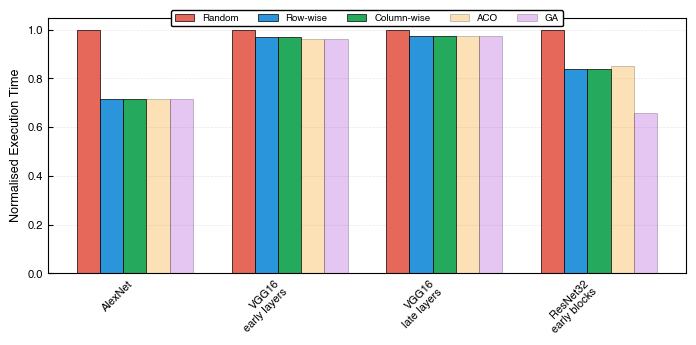

In [53]:
# Generate the mapping comparison plot
fig, ax = plot_mapping_comparison_ieee(
    model_dataframes=model_dataframes_normalised,
    figsize=(7.0, 3.5),
    use_norm=True,
    save_path='../data/mapping_comparison_not_all_models.png',
    dpi=800
)

plt.show()

### Broken y axis for better visibility